In [98]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 18
%matplotlib inline

# Governing choices for search
N_FOLDS = 5
MAX_EVALS = 5

In [99]:
features = pd.read_csv('../dataset/application_train.csv')

# Sample 16000 rows (10000 for training, 6000 for testing)
features = features.sample(n = 16000, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 42)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

Train shape:  (10000, 104)
Test shape:  (6000, 104)


## Baseline Model

First we can create a model with the default value of hyperparameters and score it using cross validation with early stopping. Using the cv LightGBM function requires creating a Dataset.

In [100]:
model = lgb.LGBMClassifier(random_state=50)
hyperparameters = model.get_params()
# Training set
train_set = lgb.Dataset(train_features, label = train_labels)
test_set = lgb.Dataset(test_features, label = test_labels)


In [101]:
# Default hyperparamters
# hyperparameters = model.get_params()

# Using early stopping to determine number of estimators.
del hyperparameters['n_estimators']

# Perform cross validation with early stopping
cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 42)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['auc-mean'])))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:661: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


The maximium ROC AUC in cross validation was 0.70867 with std of 0.02098.
The ideal number of iterations was 33.


In [102]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.71466 ROC AUC on the test set.


## Objective Function

The first part to write is the objective function which takes in a set of hyperparameter values and returns the cross validation score on the training data. An objective function in Hyperopt must return either a single real value to minimize, or a dictionary with a key "loss" with the score to minimize (and a key "status" indicating if the run was successful or not).

Optimization is typically about minimizing a value, and because our metric is Receiver Operating Characteristic Area Under the Curve (ROC AUC) where higher is better, the objective function will return  1−ROC AUC Cross Validation . The algorithm will try to drive this value as low as possible (raising the ROC AUC) by choosing the next hyperparameters based on the past results.

The complete objective function is shown below. As with random and grid search, we write to a csv file on each call of the function in order to track results as the search progress and so we have a saved record of the search. (The subsample and boosting_type logic will be explained when we get to the domain).

In [103]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

In [104]:
def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Using early stopping to find number of trees trained
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type and subsample to top level keys
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)

    run_time = timer() - start
    
    # Extract the best score
    best_score = cv_results['auc-mean'][-1]
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = len(cv_results['auc-mean'])
    
    # Add the number of estimators to the hyperparameters
    hyperparameters['n_estimators'] = n_estimators

    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

## Domain

Specifying the domain (called the space in Hyperopt) is a little trickier than in grid search. In Hyperopt, and other Bayesian optimization frameworks, the domian is not a discrete grid but instead has probability distributions for each hyperparameter. For each hyperparameter, we will use the same limits as with the grid, but instead of being defined at each point, the domain represents probabilities for each hyperparameter. This will probably become clearer in the code and the images!

In [105]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

In [106]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}
learning_rate

{'learning_rate': <hyperopt.pyll.base.Apply at 0x1f892cff860>}

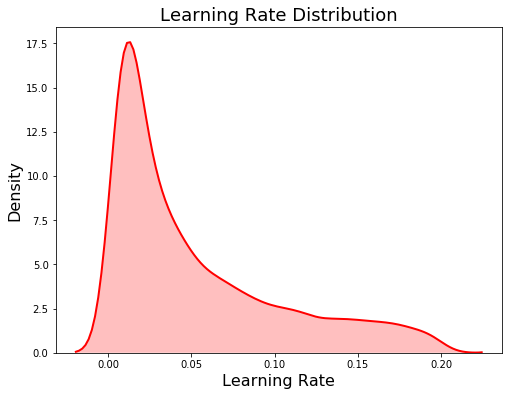

In [107]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

In [108]:
sample(learning_rate)['learning_rate']

0.019167213530938754

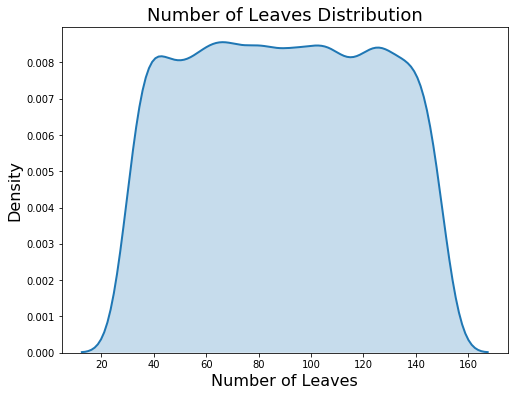

In [109]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

In [110]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

hyperparams = sample(boosting_type)
hyperparams

{'boosting_type': {'boosting_type': 'gbdt', 'subsample': 0.891072550839572}}

In [111]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = hyperparams['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
hyperparams['boosting_type'] = hyperparams['boosting_type']['boosting_type']
hyperparams['subsample'] = subsample

hyperparams

{'boosting_type': 'gbdt', 'subsample': 0.891072550839572}

## Complete Bayesian Domain

Now we can define the entire domain. Each variable needs to have a label and a few parameters specifying the type and extent of the distribution. For the variables such as boosting type that are categorical, we use the choice variable. Other variables types include quniform, loguniform, and uniform. For the complete list, check out the documentation for Hyperopt. Altogether there are 10 hyperparameters to optimize.

In [112]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

In [113]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'goss',
 'colsample_bytree': 0.7323462934048498,
 'is_unbalance': False,
 'learning_rate': 0.03380797501575006,
 'min_child_samples': 30.0,
 'num_leaves': 20.0,
 'reg_alpha': 0.6229831014424929,
 'reg_lambda': 0.8431148881188196,
 'subsample': 1.0,
 'subsample_for_bin': 240000.0}

In [114]:
# x = sample(space)
# subsample = x['boosting_type'].get('subsample', 1.0)
# x['boosting_type'] = x['boosting_type']['boosting_type']
# x['subsample'] = subsample
# x

In [115]:
# Create a new file and open a connection
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# Test the objective function
results = objective(sample(space))
print('The cross validation loss = {:.5f}.'.format(results['loss']))
print('The optimal number of estimators was {}.'.format(results['hyperparameters']['n_estimators']))

The cross validation loss = 0.34207.
The optimal number of estimators was 2.


## Optimization Algorithm

The optimization algorithm is the method for constructing the surrogate function (probability model) and selecting the next set of hyperparameters to evaluate in the objective function. Hyperopt has two choices: random search and Tree Parzen Estimator.

The technical details of TPE can be found in this article and a conceptual explanation is in this article. Although this is the most technical part of Bayesian hyperparameter optimization, defining the algorithm in Hyperopt is simple.

In [116]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest

In [117]:
tpe_algorithm

<function hyperopt.tpe.suggest>

In [118]:
from hyperopt import Trials

# Record results
trials = Trials()

In [119]:
# Create a file and open a connection
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

## Automated Hyperparameter Optimization in Practice

We have all four parts we need to run the optimization. To run Bayesian optimization we use the fmin function (a good reminder that we need a metric to minimize!)

In [120]:
from hyperopt import fmin

In [121]:
# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, trials=trials,
            max_evals=MAX_EVALS)
best

{'boosting_type': 0,
 'colsample_by_tree': 0.7241264842148791,
 'gdbt_subsample': 0.847285762610728,
 'is_unbalance': 1,
 'learning_rate': 0.0962775533913909,
 'min_child_samples': 495.0,
 'num_leaves': 98.0,
 'reg_alpha': 0.8931310354650198,
 'reg_lambda': 0.8594943446032418,
 'subsample_for_bin': 160000.0}

In [122]:
trials_dict = sorted(trials.results, key=lambda x: x['loss'])
trials_dict[:1]

[{'hyperparameters': {'boosting_type': 'gbdt',
   'colsample_bytree': 0.7241264842148791,
   'is_unbalance': False,
   'learning_rate': 0.0962775533913909,
   'metric': 'auc',
   'min_child_samples': 495,
   'n_estimators': 61,
   'num_leaves': 98,
   'reg_alpha': 0.8931310354650198,
   'reg_lambda': 0.8594943446032418,
   'subsample': 0.847285762610728,
   'subsample_for_bin': 160000,
   'verbose': 1},
  'iteration': 1,
  'loss': 0.27599435677256123,
  'status': 'ok',
  'train_time': 1.8918425931269667}]

In [123]:
# write the result to file
results = pd.read_csv(OUT_FILE)

In [124]:
import ast

In [141]:
def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
    new_results = results.copy()
    
    # String to dictionary
    new_results['hyperparameters'] = new_results['hyperparameters'].map(ast.literal_eval)
    
    # Sort by score
    new_results = new_results.sort_values('score', ascending=False).reset_index(drop=True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, new_results.loc[0, 'score'], new_results.loc[0, 'iteration']))
    
    hyperparameters = new_results.loc[0, 'hyperparameters']
    
    model = lgb.LGBMClassifier(**hyperparameters)
    
    model.fit(train_features, train_labels)
    
    preds = model.predict_proba(test_features)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
    hyp_df = pd.DataFrame(columns=list(new_results.loc[0, 'hyperparameters'].keys()))
    
    for i, hyp in enumerate(new_results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index=[0]), ignore_index=True)
        
    hyp_df['iteration'] = new_results['iteration']
    hyp_df['score'] = new_results['score']
    
    return hyp_df

In [142]:
bayes_results = evaluate(results, name = 'Bayesian')
bayes_results

The highest cross validation score from Bayesian was 0.72401 found on iteration 1.
ROC AUC from Bayesian on test data = 0.72915.


,boosting_type,colsample_bytree,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,metric,verbose,n_estimators,iteration,score
0,gbdt,0.724126,False,0.096278,495,98,0.893131,0.859494,160000,0.847286,auc,1,61,1,0.724006
1,gbdt,0.802754,False,0.022991,120,90,0.822210,0.629289,140000,0.775588,auc,1,67,2,0.718770
2,dart,0.984194,True,0.024011,105,132,0.453730,0.096315,200000,0.724694,auc,1,64,3,0.714071
3,dart,0.964999,True,0.090136,55,105,0.265496,0.558525,100000,0.739019,auc,1,27,5,0.700552
4,dart,0.884520,True,0.070725,40,117,0.457680,0.603520,220000,0.608705,auc,1,14,4,0.696268


In [137]:
results.loc[0, 'hyperparameters']

"{'boosting_type': 'gbdt', 'colsample_bytree': 0.7241264842148791, 'is_unbalance': False, 'learning_rate': 0.0962775533913909, 'min_child_samples': 495, 'num_leaves': 98, 'reg_alpha': 0.8931310354650198, 'reg_lambda': 0.8594943446032418, 'subsample_for_bin': 160000, 'subsample': 0.847285762610728, 'metric': 'auc', 'verbose': 1, 'n_estimators': 61}"

In [143]:
MAX_EVALS = 10

In [146]:
best = fmin(fn=objective, space=space, algo=tpe.suggest, trials=trials, max_evals=MAX_EVALS)

In [147]:
best

{'boosting_type': 0,
 'colsample_by_tree': 0.7241264842148791,
 'gdbt_subsample': 0.847285762610728,
 'is_unbalance': 1,
 'learning_rate': 0.0962775533913909,
 'min_child_samples': 495.0,
 'num_leaves': 98.0,
 'reg_alpha': 0.8931310354650198,
 'reg_lambda': 0.8594943446032418,
 'subsample_for_bin': 160000.0}

In [148]:
import json

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(trials_dict))  # trials_dict:得分最高的参数

To start the training from where it left off, simply load in the Trials object and pass it to an instance of fmin. (You might even be able to tweak the hyperparameter distribution and continue searching with the Trials object because the algorithm does not maintain an internal state. Someone should check this and let me know in the comments!).

## Next Steps

Now that we have developed all the necessary parts for automated hyperparameter tuning using Bayesian optimization, we can apply these to any dataset or any machine learning method. The functions taken here can be put in a script and run a full dataset. Next, we will go through results from 1000 evaluations on a reduced size dataset to see how the search progresses. We can then compare these results to random search to see how a method that uses reasoning about past results differs from a method that does not.

After examining the tuning results from the reduced dataset, we will take the best performing hyperparameters and see if these translate to a full dataset, the features from the [Updated 0.792 LB] LightGBM with Simple Features(https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) kernel (I did not develop these features and want to give credit to the numerous people, including Aguiar and olivier, who have worked on these features. Please check out their kernels!). We saw in the random and grid search notebook that the best hyperparameter values from the small datasets do not necessarily perform well on the full datasets. I am currently running the Bayesian Hyperparameter optimization for 500 iterations on the features referenced above and will make the results publicly available when the search is finished. For now, we will turn to the 1000 trials from the smaller dataset. These results can be generated by running the cell below, but I can't guarantee if this will finish within the kernel time limit!

In [150]:
import csv
# write to file
def write2file(fname, results, write_header=False, header=['loss', 'hyperparameters', 'iteration', 'runtime', 'score']):
    f = open(fname, 'a')
    w = csv.writer(f)
    
    if write_header:
        w.writerow(header)
    w.writerow(results)
    f.close()

In [159]:
# Create a new file and open a connection
OUT_FILE = 'bayesian_trials_1000.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

MAX_EVALS = 10

# Record results
trials = Trials()

global ITERATION

ITERATION = 0 

best = fmin(fn = objective, space = space, algo = tpe.suggest,
            trials = trials, max_evals = MAX_EVALS)

# Sort the trials with lowest loss (highest AUC) first
trials_dict = sorted(trials.results, key = lambda x: x['loss'])

print('Finished, best results')
print(trials_dict[:1])

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(trials_dict))

Finished, best results
[{'loss': 0.2750933981264718, 'hyperparameters': {'boosting_type': 'gbdt', 'colsample_bytree': 0.6927589848056876, 'is_unbalance': True, 'learning_rate': 0.0347379889598716, 'min_child_samples': 245, 'num_leaves': 39, 'reg_alpha': 0.900274036192737, 'reg_lambda': 0.5129107604069054, 'subsample_for_bin': 160000, 'subsample': 0.5095983833727704, 'metric': 'auc', 'verbose': 1, 'n_estimators': 86}, 'iteration': 9, 'train_time': 3.3903193939277116, 'status': 'ok'}]


## Ｓｅａｒｃｈ　ｒｅｓｕｌｔ

In [160]:
bayes_results = pd.read_csv('bayesian_trials_1000.csv').sort_values('score', ascending = False).reset_index()
random_results = pd.read_csv('random_search_trials_1000.csv').sort_values('score', ascending = False).reset_index()
random_results['loss'] = 1 - random_results['score']

bayes_params = evaluate(bayes_results, name = 'Bayesian')
random_params = evaluate(random_results, name = 'random')

The highest cross validation score from Bayesian was 0.72491 found on iteration 9.
ROC AUC from Bayesian on test data = 0.72546.
The highest cross validation score from random was 0.72088 found on iteration 6.
ROC AUC from random on test data = 0.73430.


In [167]:
scores = pd.DataFrame({'ROC AUC': random_params['score'], 'iteration': random_params['iteration'], 'search': 'Random'})
scores = scores.append(pd.DataFrame({'ROC AUC': bayes_params['score'], 'iteration': bayes_params['iteration'], 'search': 'Bayesian'}))
scores.head

<bound method NDFrame.head of     ROC AUC  iteration    search
0  0.720879          6    Random
1  0.719677          0    Random
2  0.716500          3    Random
3  0.715478          9    Random
4  0.714478          4    Random
5  0.714344          2    Random
6  0.711271          1    Random
7  0.703607          8    Random
8  0.702571          5    Random
9  0.675438          7    Random
0  0.724907          9  Bayesian
1  0.723759         10  Bayesian
2  0.722454          4  Bayesian
3  0.722172          6  Bayesian
4  0.719583          7  Bayesian
5  0.717531          1  Bayesian
6  0.715358          8  Bayesian
7  0.713021          2  Bayesian
8  0.706356          5  Bayesian
9  0.690519          3  Bayesian>

In [168]:
scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

In [169]:
# We can also find the best scores for plotting the best hyperparameter values.
best_random_params = random_params.iloc[random_params['score'].idxmax(), :].copy()
best_bayes_params = bayes_params.iloc[bayes_params['score'].idxmax(), :].copy()

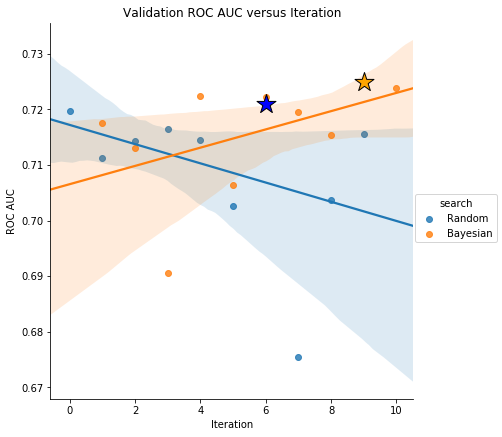

In [180]:
sns.lmplot('iteration', 'ROC AUC', data=scores, hue='search', size=6)

plt.scatter(best_bayes_params['iteration'], best_bayes_params['score'], marker = '*', s = 400, c = 'orange', edgecolor = 'k')
plt.scatter(best_random_params['iteration'], best_random_params['score'], marker = '*', s = 400, c = 'b', edgecolor = 'k')

plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("Validation ROC AUC versus Iteration")
plt.show()

## Learning Rate Distribution

Next we can start plotting the distributions of hyperparameter values searched. We expect random search to align with the search domain, while the Bayesian hyperparameter optimization should tend to focus on more promising values, wherever those happen to be in the search domain.

The dashed vertical lines indicate the "optimal" value of the hyperparameter.

Text(0.5,1,'Learning Rate Distribution')

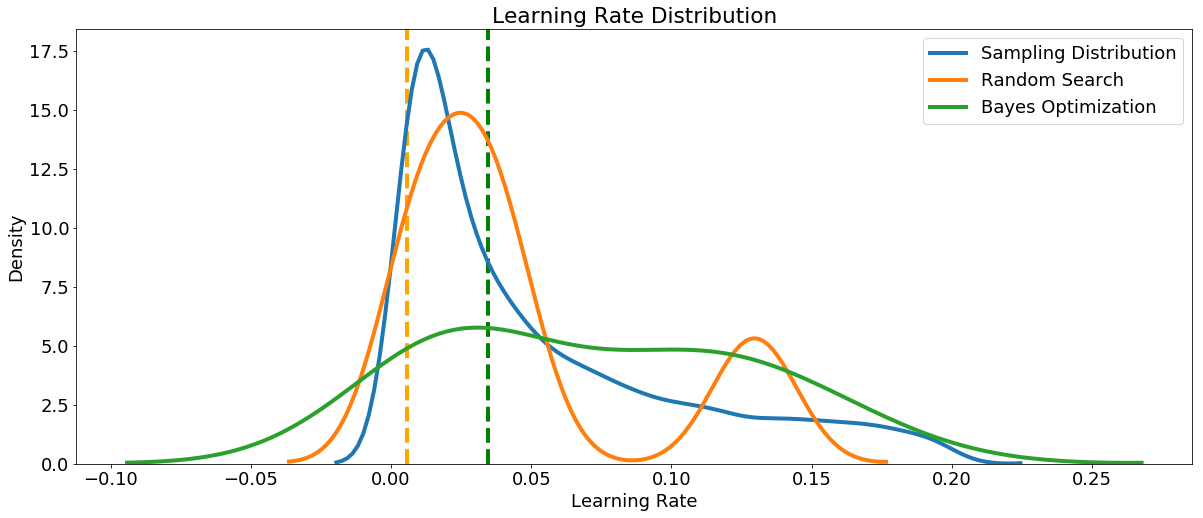

In [181]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 4)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 4)
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', linewidth = 4)
plt.vlines([best_random_params['learning_rate'], best_bayes_params['learning_rate']],
           ymin = 0.0, ymax = 50.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution')

## Distribution of all Numeric Hyperparameters

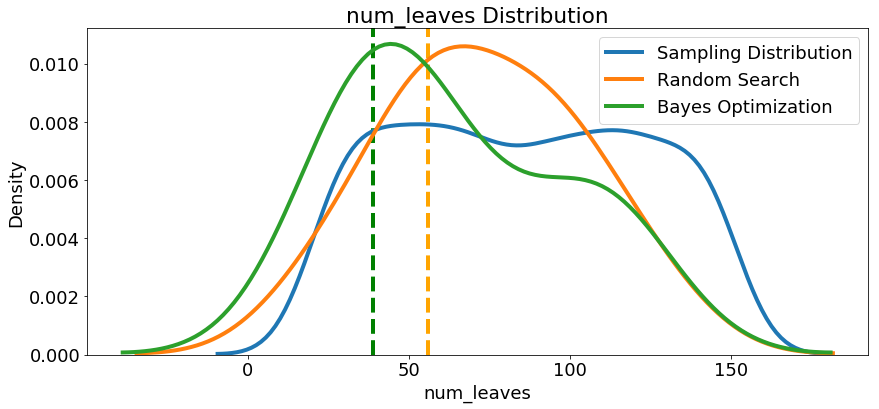

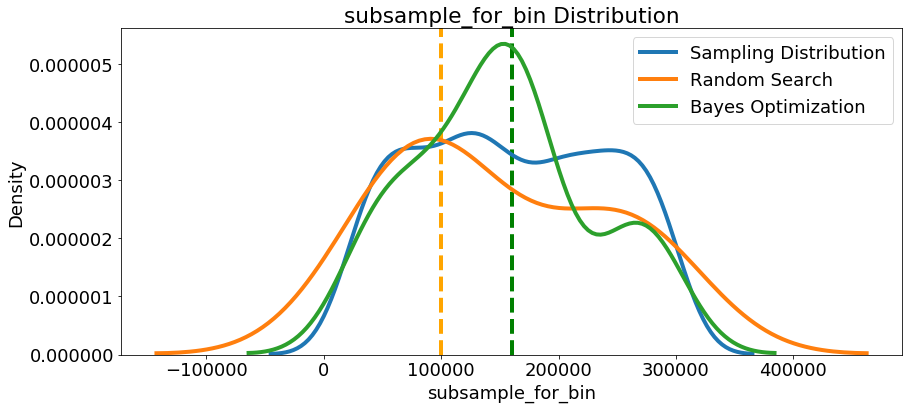

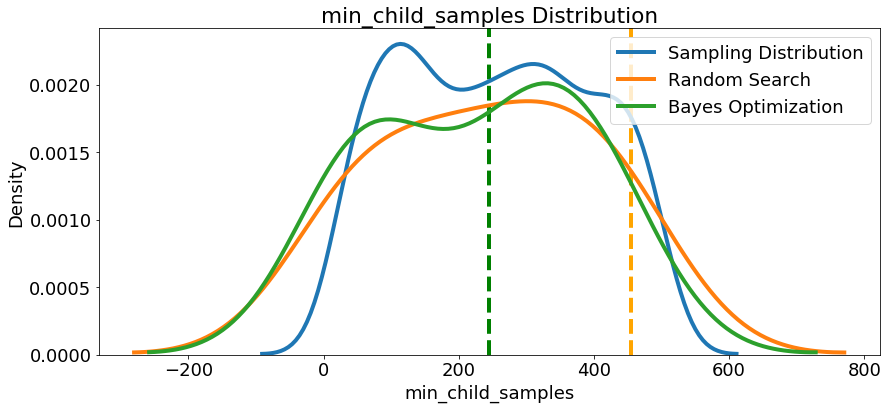

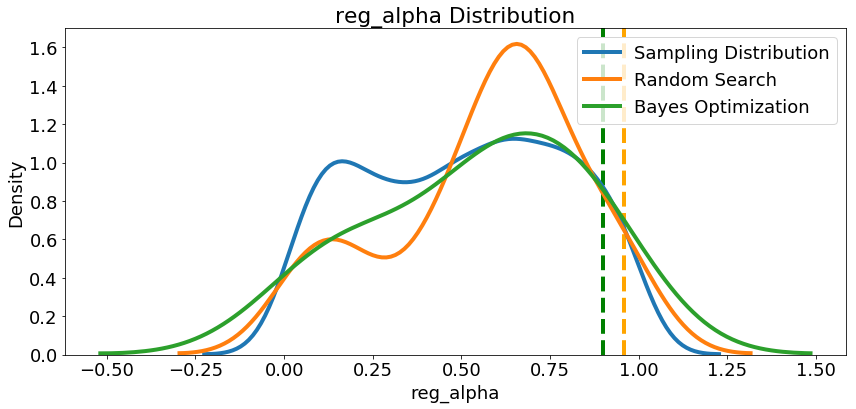

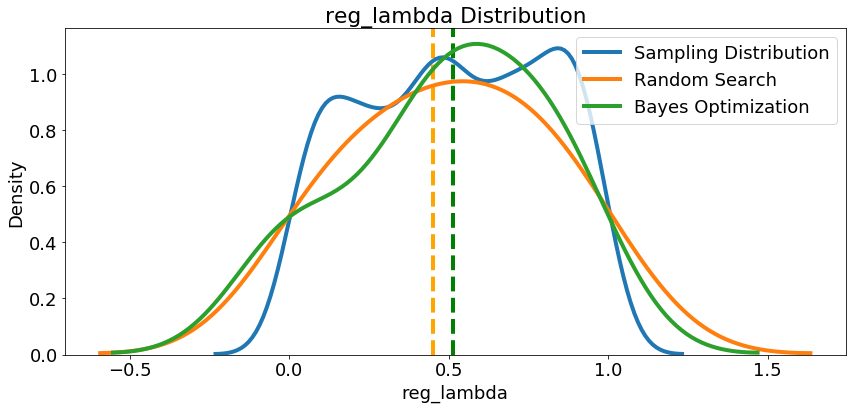

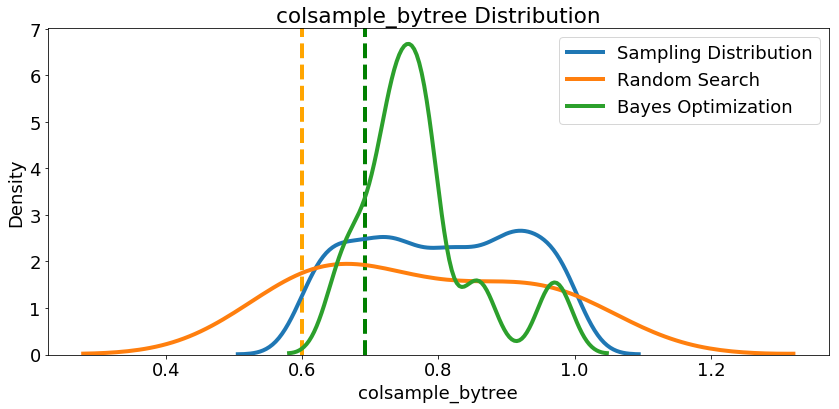

In [182]:
# Iterate through each hyperparameter
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'n_estimators', 'score', 'is_unbalance',
                    'boosting_type', 'iteration', 'subsample', 'metric', 'verbose', 'loss', 'learning_rate']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution', linewidth = 4)
        sns.kdeplot(random_params[hyper], label = 'Random Search', linewidth = 4)
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization', linewidth = 4)
        plt.vlines([best_random_params[hyper], best_bayes_params[hyper]],
                     ymin = 0.0, ymax = 10.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show()

## Evolution of Search

An interesting series of plots to make is the evolution of the hyperparameters over the search. This can show us what values the Bayesian optimization tended to focus on. The average cross validation score continued to improve throughout Bayesian optimization, indicating that "more promising" values of the hyperparameters were being evaluated and maybe a longer search would prove useful (or there could be a plateau in the validation scores with a longer search).

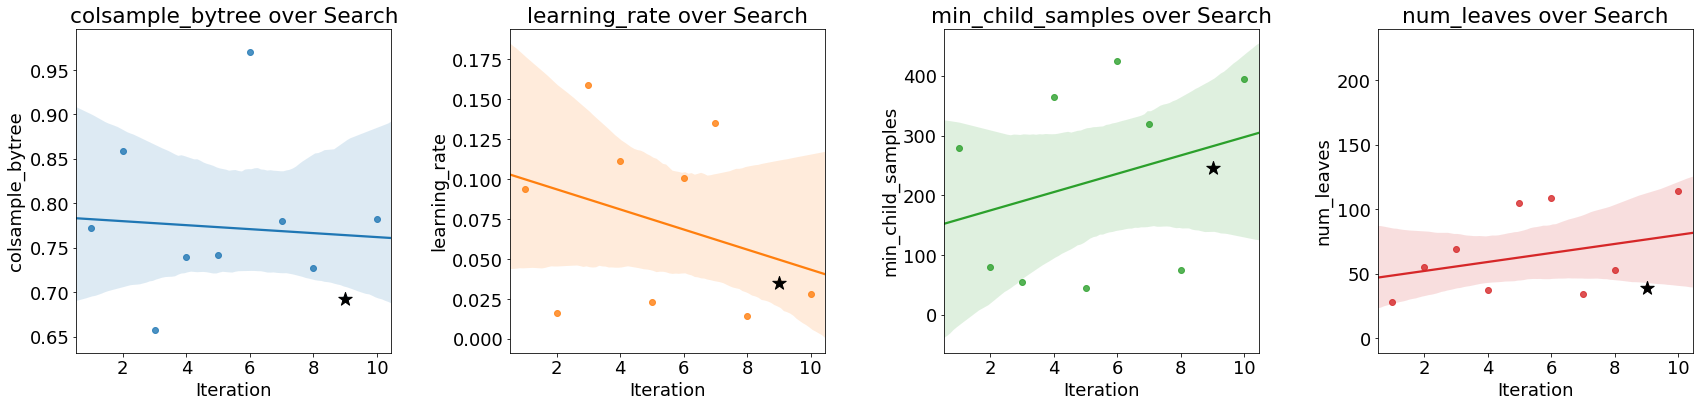

In [185]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
    
        # Scatterplot
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].scatter(best_bayes_params['iteration'], best_bayes_params[hyper], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

## Applied to Full Dataset